In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/DiffEq-jl-demo`


In [3]:

using DifferentialEquations
using Catalyst
using Plots
using Turing

using Statistics, Distributions
using StatsPlots
using Latexify
using LinearAlgebra

# Set a seed for reproducibility.
using Random
Random.seed!(14);


In [4]:
# Create model.
model = @reaction_network begin
    # Two reactions that associate X and Y to a surface
    (k_a, k_d), X <--> X_a
    (k_a, k_d), Y <--> Y_a
    # The main reaction X + Y -> Z
    (k_f, k_r), X_a + Y_a <--> Z_a
    # Dissociate Z
    (k_d, k_a), Z_a <--> Z
end


Model ##ReactionSystem#235:
Unknowns (6): see unknowns(##ReactionSystem#235)
  X(t)
  X_a(t)
  Y(t)
  Y_a(t)
  ⋮
Parameters (4): see parameters(##ReactionSystem#235)
  k_a
  k_d
  k_f
  k_r

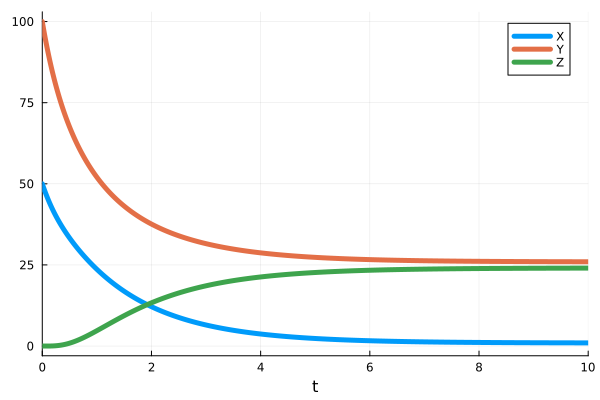

In [ ]:
# Create an ODE that can be simulated.
# Initial Conditions
u0 = [:X => 50.0, :Y => 100.0, :X_a => 0.0, :Y_a => 0.0, :Z_a => 0.0, :Z => 0.0]
# Time range
tspan = (0.0, 10.0)
# Parameters
ps = [:k_a => 1.0, :k_d => 1.0, :k_f=> 0.1, :k_r => 0.1]
ode = ODEProblem(model, u0, tspan, ps)

# Simulate ODE and plot results.
sol = solve(ode);
plot(sol; idxs = [:X, :Y, :Z], lw=5)


In [6]:
latexify(model)

L"\begin{align*}
\mathrm{X} &\xrightleftharpoons[\mathtt{k_{d}}]{\mathtt{k_{a}}} \mathrm{\mathtt{X_{a}}} \\
\mathrm{Y} &\xrightleftharpoons[\mathtt{k_{d}}]{\mathtt{k_{a}}} \mathrm{\mathtt{Y_{a}}} \\
\mathrm{\mathtt{X_{a}}} + \mathrm{\mathtt{Y_{a}}} &\xrightleftharpoons[\mathtt{k_{r}}]{\mathtt{k_{f}}} \mathrm{\mathtt{Z_{a}}} \\
\mathrm{\mathtt{Z_{a}}} &\xrightleftharpoons[\mathtt{k_{a}}]{\mathtt{k_{d}}} \mathrm{Z}  
 \end{align*}
"

# Forward Problems are Cool but let's solve an inverse problem!

In [15]:
# Generate synthetic data: assume we got some data from an experiment, it follows a "True" model
oprob_true = ODEProblem(model, u0, (0.0, 10.0), ps)
# We'll solve it 
true_sol = solve(oprob_true)
# Let's solve it again and save every 1.5 seconds
data_sol = solve(oprob_true; saveat=1.5);
data_ts = data_sol.t[1:end]
println(data_ts)

In [16]:
# We'll add some noise to the "True" model, which is what we would expect!
noise_vals = rand(Normal(0.0, 5.0), (3, 8))

data_vals = noise_vals .+ hcat(data_sol[[:X, :Y, :Z]][1:end]...);

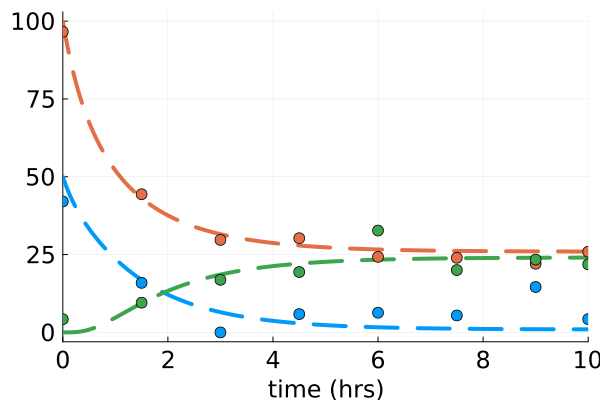

In [ ]:
# # Plots the true solutions and the (synthetic) data measurements.
plot(true_sol; 
        idxs=[:X, :Y, :Z],
        labels=[ "X_true" "Y_true" "Z_true"],
        color = [1 2 3],
        lw=4,
        linestyle=:dash,
        xtickfontsize=16,
        ytickfontsize=16,
        xlabel="time (hrs)",
        legendfontsize=16,
        xguidefontsize=16,
        legend=false)
plot!(data_ts, transpose(data_vals), 
        labels=["X_obs" "Y_obs" "Z_obs"], 
        seriestype = :scatter, color=[1 2 3], 
        ms=6)
#savefig("True_and_data.svg")

In [20]:
sol = solve(oprob_true, Tsit5(), saveat=1.5)

retcode: Success
Interpolation: 1st order linear
t: 8-element Vector{Float64}:
  0.0
  1.5
  3.0
  4.5
  6.0
  7.5
  9.0
 10.0
u: 8-element Vector{Vector{Float64}}:
 [50.0, 0.0, 100.0, 0.0, 0.0, 0.0]
 [16.884905205201974, 5.591425436395284, 43.129525451225604, 29.346805190371647, 18.16395431758108, 9.359715040821667]
 [6.49011342587813, 2.6217224840846822, 31.552099549089796, 27.55973636087301, 22.316291392703654, 18.571872697333536]
 [2.9047812633791366, 1.5506879455287723, 27.90787175251554, 26.547597456392367, 23.44622156533482, 22.098309225757276]
 [1.6381748893086905, 1.1551250918029825, 26.63832916156621, 26.154970819545447, 23.844720635939495, 23.361979382948835]
 [1.184344146083037, 1.0107408708266417, 26.184352139962083, 26.010732876947575, 23.989251135294307, 23.815663847796024]
 [1.0210011325203125, 0.9577451055448765, 26.021001590734777, 25.957744647330394, 24.04225443624067, 23.97899932569414]
 [0.9754281722719976, 0.9431455181191647, 25.975428238379894, 25.943145452011247

In [21]:
@model function fit_crn(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2., 3.)
    
    k_a ~ LogNormal(-1.0, 1.0)
    k_d ~ LogNormal(1.0, 1.0)

    k_f ~ LogNormal(-1.0, 1.0)
    k_r ~ LogNormal(-1.0, 1.0)

    # Simulate CRN model. 
    p = [:k_a => k_a, :k_d => k_d, :k_f => k_f, :k_r => k_r]
    predicted = solve(remake(prob, p = p), AutoTsit5(Rosenbrock23()); saveat=1.5)
    preds = predicted[[:X, :Y, :Z]]
    # Observations.
    for i in 1:length(preds)
        data[:, i] ~ MvNormal(preds[i], σ^2 * I)
        
    end

    return nothing
end

fit_model = fit_crn(data_vals, oprob_true)
# Sample 3 independent chains with forward-mode automatic differentiation (the default).
chain = sample(fit_model, NUTS(0.65), MCMCSerial(), 1000, 3; progress=true)

Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 384.92 seconds
Compute duration  = 383.96 seconds
parameters        = σ, k_a, k_d, k_f, k_r
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    4.9036    0.7420    0.0173   1915.4818   1744.9125    1.0018   ⋯
         k_a    0.9402    0.2254    0.0079   1043.2475    897.5878    1.0025   ⋯
         k_d    0.9131    0.2573    0.0088   1061.2933    943.9574    1.0015   ⋯
         k_f    0.4479    0.5076    0.0117   1374.6310   1629.4040    1.0037   ⋯
         k_r    0.6354    0.6072    0.0134   1716

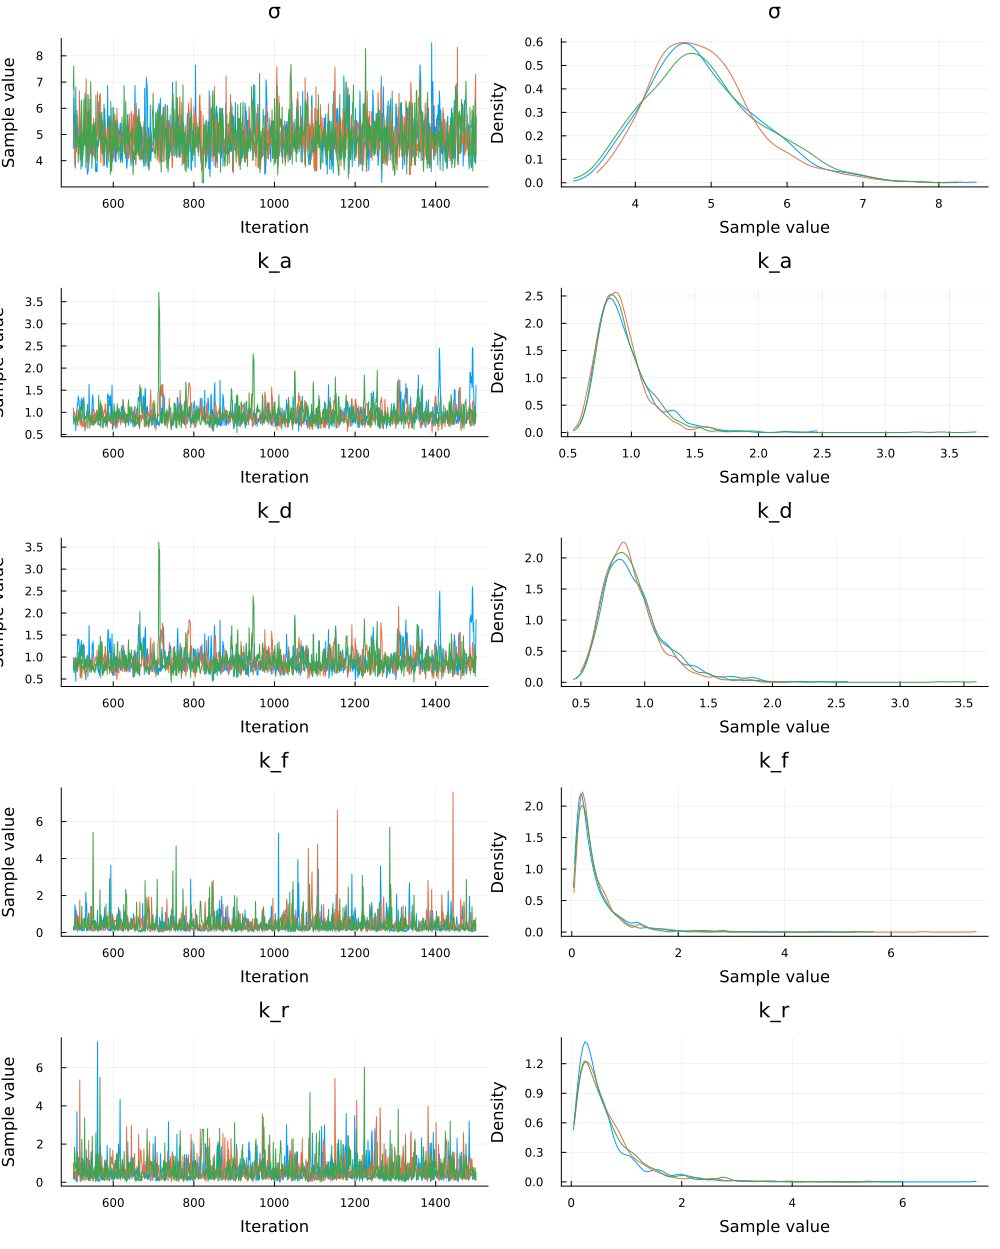

In [22]:
plot(chain)

# Plot the solutions! 

In [52]:
posterior_samples = sample(chain[[:k_a, :k_d, :k_f, :k_r]], 300; replace=false);


In [56]:
plot(; legend=false)

for p in eachrow(Array(posterior_samples))
    p_n = [:k_a=>p[1], :k_d=> p[2], :k_f=> p[3], :k_r=> p[4]]
    sol_p = solve(remake(oprob_true, p=p_n), AutoTsit5(Rosenbrock23()); saveat=0.1)
    plot!(sol_p, idxs=[:X, :Y, :Z]; labels= [nothing nothing nothing], lw = 1.5, alpha=0.1, color=[1 2 3])
end


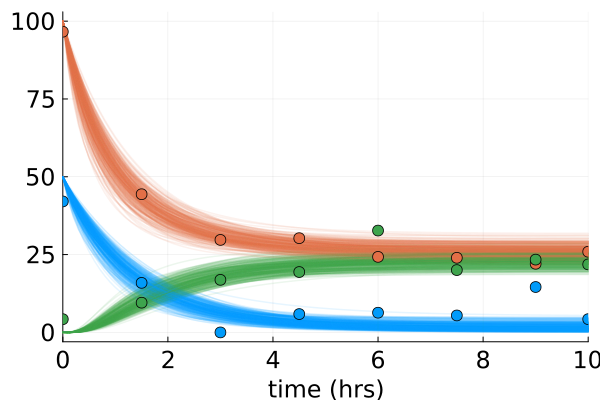

In [ ]:
#
p = eachrow(Array(posterior_samples))[end]
p_n = [:k_a=>p[1], :k_d=> p[2], :k_f=> p[3], :k_r=> p[4]]

sol_p = solve(remake(oprob_true, p=p_n), AutoTsit5(Rosenbrock23()); saveat=0.1)
plot!(sol_p, idxs=[:X, :Y, :Z]; labels=["X_infer" "Y_infer" "Z_infer"], alpha=0.5, color=[1 2 3])
# Plot simulation and noisy observations
scatter!(sol.t, data_vals'; 
        color = [1 2 3],
        ms=6,
        labels=["X_obs" "Y_obs" "Z_obs"],
        xtickfontsize=16,
        ytickfontsize=16,
        xlabel="time (hrs)",
        legendfontsize=14,
        xguidefontsize=16)
# savefig("Infered_and_data.svg")